In [ ]:
problem_statement = """
Smart City Traffic Management & Congestion Analysis

| Objective:
Analyze traffic patterns in Bengaluru to:
- Identify congestion hotspots
- Predict peak traffic hours
- Assess accident risks
- Recommend improvements to reduce delays & accidents

Dataset: https://www.kaggle.com/datasets/preethamgouda/banglore-city-traffic-dataset
(kaggle)
"""

print(problem_statement)


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import joblib


In [4]:
# Load dataset 
df = pd.read_csv("./datasets/Banglore_traffic_Dataset.csv")

print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns.tolist())

print(df.info())

df.head()


Shape of dataset: (8936, 16)

Columns:
 ['Date', 'Area Name', 'Road/Intersection Name', 'Traffic Volume', 'Average Speed', 'Travel Time Index', 'Congestion Level', 'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Weather Conditions', 'Roadwork and Construction Activity']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                8936 non-null   object 
 1   Area Name                           8936 non-null   object 
 2   Road/Intersection Name              8936 non-null   object 
 3   Traffic Volume                      8936 non-null   int64  
 4   Average Speed                       8936 non-null   float64
 5   Travel Time Index               

Date    Area Name Road/Intersection Name  Traffic Volume  \
0  2022-01-01  Indiranagar          100 Feet Road           50590   
1  2022-01-01  Indiranagar               CMH Road           30825   
2  2022-01-01   Whitefield    Marathahalli Bridge            7399   
3  2022-01-01  Koramangala    Sony World Junction           60874   
4  2022-01-01  Koramangala          Sarjapur Road           57292   

   Average Speed  Travel Time Index  Congestion Level  \
0      50.230299           1.500000        100.000000   
1      29.377125           1.500000        100.000000   
2      54.474398           1.039069         28.347994   
3      43.817610           1.500000        100.000000   
4      41.116763           1.500000        100.000000   

   Road Capacity Utilization  Incident Reports  Environmental Impact  \
0                 100.000000                 0               151.180   
1                 100.000000                 1               111.650   
2                  36.396525                 0                64.798   
3                 100.000000                 1               171.748   
4                 100.000000                 3               164.584   

   Public Transport Usage  Traffic Signal Compliance  Parking Usage  \
0               70.632330                  84.044600      85.403629   
1               41.924899                  91.407038      59.983689   
2               44.662384                  61.375541      95.466020   
3               32.773123                  75.547092      63.567452   
4               35.092601                  64.634762      93.155171   

   Pedestrian and Cyclist Count Weather Conditions  \
0                           111              Clear   
1                           100              Clear   
2                           189              Clear   
3                           111              Clear   
4                           104              Clear   

  Roadwork and Construction Activity  
0                                 No  
1                                 No  
2                                 No  
3                                 No  
4                                 No

In [5]:
# Data Cleaning
old_rows =df.shape[0]
df = df.dropna() 

# df = df.fillna(method='ffill')   # forward fill missing values

# Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Remove duplicates
df = df.drop_duplicates()

print("Removed rows:::", old_rows - df.shape[0])

print(df.info())
df.shape

Removed rows::: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Date                                8936 non-null   datetime64[ns]
 1   Area Name                           8936 non-null   object        
 2   Road/Intersection Name              8936 non-null   object        
 3   Traffic Volume                      8936 non-null   int64         
 4   Average Speed                       8936 non-null   float64       
 5   Travel Time Index                   8936 non-null   float64       
 6   Congestion Level                    8936 non-null   float64       
 7   Road Capacity Utilization           8936 non-null   float64       
 8   Incident Reports                    8936 non-null   int64         
 9   Environmental Impact                8936 non-null   float64       
 10  Public

(8936, 16)

In [6]:
# Show unique values in categorical columns
print("Area Names:", df['Area Name'].unique(), "\n")
print("Road/Intersection Names:", df['Road/Intersection Name'].unique(), "\n")
print("Weather Conditions:", df['Weather Conditions'].unique(), "\n")
print("Roadwork/Construction Activity:", df['Roadwork and Construction Activity'].unique(), "\n")


Area Names: ['Indiranagar' 'Whitefield' 'Koramangala' 'M.G. Road' 'Jayanagar' 'Hebbal'
 'Yeshwanthpur' 'Electronic City'] 

Road/Intersection Names: ['100 Feet Road' 'CMH Road' 'Marathahalli Bridge' 'Sony World Junction'
 'Sarjapur Road' 'Trinity Circle' 'Anil Kumble Circle'
 'Jayanagar 4th Block' 'South End Circle' 'Hebbal Flyover' 'Ballari Road'
 'Yeshwanthpur Circle' 'Tumkur Road' 'ITPL Main Road'
 'Silk Board Junction' 'Hosur Road'] 

Weather Conditions: ['Clear' 'Overcast' 'Fog' 'Rain' 'Windy'] 

Roadwork/Construction Activity: ['No' 'Yes'] 



In [7]:
# Feature Engineering
from sklearn.preprocessing import LabelEncoder

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Encode categorical features
le_area = LabelEncoder()
df['Area Name'] = le_area.fit_transform(df['Area Name'])

le_road = LabelEncoder()
df['Road/Intersection Name'] = le_road.fit_transform(df['Road/Intersection Name'])

le_weather = LabelEncoder()
df['Weather Conditions'] = le_weather.fit_transform(df['Weather Conditions'])

le_roadwork = LabelEncoder()
df['Roadwork and Construction Activity'] = le_roadwork.fit_transform(df['Roadwork and Construction Activity'])

df.head()


Date  Area Name  Road/Intersection Name  Traffic Volume  \
0 2022-01-01          2                       0           50590   
1 2022-01-01          2                       3           30825   
2 2022-01-01          6                       8            7399   
3 2022-01-01          4                      11           60874   
4 2022-01-01          4                       9           57292   

   Average Speed  Travel Time Index  Congestion Level  \
0      50.230299           1.500000        100.000000   
1      29.377125           1.500000        100.000000   
2      54.474398           1.039069         28.347994   
3      43.817610           1.500000        100.000000   
4      41.116763           1.500000        100.000000   

   Road Capacity Utilization  Incident Reports  Environmental Impact  \
0                 100.000000                 0               151.180   
1                 100.000000                 1               111.650   
2                  36.396525                 0                64.798   
3                 100.000000                 1               171.748   
4                 100.000000                 3               164.584   

   Public Transport Usage  Traffic Signal Compliance  Parking Usage  \
0               70.632330                  84.044600      85.403629   
1               41.924899                  91.407038      59.983689   
2               44.662384                  61.375541      95.466020   
3               32.773123                  75.547092      63.567452   
4               35.092601                  64.634762      93.155171   

   Pedestrian and Cyclist Count  Weather Conditions  \
0                           111                   0   
1                           100                   0   
2                           189                   0   
3                           111                   0   
4                           104                   0   

   Roadwork and Construction Activity  Year  Month  Day  DayOfWeek  
0                                   0  2022      1    1          5  
1                                   0  2022      1    1          5  
2                                   0  2022      1    1          5  
3                                   0  2022      1    1          5  
4                                   0  2022      1    1          5

In [8]:
# Exploratory Data Analysis (EDA)

import calendar

df_plot = df.copy()

# Decode Label Encoded columns
df_plot['Area Name'] = le_area.inverse_transform(df_plot['Area Name'])
df_plot['Road/Intersection Name'] = le_road.inverse_transform(df_plot['Road/Intersection Name'])
df_plot['Weather Conditions'] = le_weather.inverse_transform(df_plot['Weather Conditions'])
df_plot['Roadwork and Construction Activity'] = le_roadwork.inverse_transform(df_plot['Roadwork and Construction Activity'])

# Map 0-6 to Monday-Sunday
df_plot['Day Name'] = df_plot['DayOfWeek'].map(lambda x: calendar.day_name[x])
day_order = list(calendar.day_name)  # Monday → Sunday
df_plot['Day Name'] = pd.Categorical(df_plot['Day Name'], categories=day_order, ordered=True)

# Map numeric Month (1-12) to month names
df_plot['Month Name'] = df_plot['Month'].map(lambda x: calendar.month_name[x])
month_order = list(calendar.month_name)[1:]  # January → December
df_plot['Month Name'] = pd.Categorical(df_plot['Month Name'], categories=month_order, ordered=True)

print(df_plot[['DayOfWeek','Day Name','Month','Month Name']].head())


   DayOfWeek  Day Name  Month Month Name
0          5  Saturday      1    January
1          5  Saturday      1    January
2          5  Saturday      1    January
3          5  Saturday      1    January
4          5  Saturday      1    January


In [9]:
# Area Name
area_map = pd.DataFrame({
    'Encoded': df['Area Name'],
    'Text': df_plot['Area Name']
}).drop_duplicates().sort_values('Encoded').reset_index(drop=True)

print("Area Name Mapping:\n", area_map)

# Road/Intersection Name
road_map = pd.DataFrame({
    'Encoded': df['Road/Intersection Name'],
    'Text': df_plot['Road/Intersection Name']
}).drop_duplicates().sort_values('Encoded').reset_index(drop=True)

print("\nRoad/Intersection Name Mapping:\n", road_map)

# Weather Conditions
weather_map = pd.DataFrame({
    'Encoded': df['Weather Conditions'],
    'Text': df_plot['Weather Conditions']
}).drop_duplicates().sort_values('Encoded').reset_index(drop=True)

print("\nWeather Conditions Mapping:\n", weather_map)

# Roadwork
roadwork_map = pd.DataFrame({
    'Encoded': df['Roadwork and Construction Activity'],
    'Text': df_plot['Roadwork and Construction Activity']
}).drop_duplicates().sort_values('Encoded').reset_index(drop=True)


print("\nRoadwork Mapping:\n", roadwork_map)

Area Name Mapping:
    Encoded             Text
0        0  Electronic City
1        1           Hebbal
2        2      Indiranagar
3        3        Jayanagar
4        4      Koramangala
5        5        M.G. Road
6        6       Whitefield
7        7     Yeshwanthpur

Road/Intersection Name Mapping:
     Encoded                 Text
0         0        100 Feet Road
1         1   Anil Kumble Circle
2         2         Ballari Road
3         3             CMH Road
4         4       Hebbal Flyover
5         5           Hosur Road
6         6       ITPL Main Road
7         7  Jayanagar 4th Block
8         8  Marathahalli Bridge
9         9        Sarjapur Road
10       10  Silk Board Junction
11       11  Sony World Junction
12       12     South End Circle
13       13       Trinity Circle
14       14          Tumkur Road
15       15  Yeshwanthpur Circle

Weather Conditions Mapping:
    Encoded      Text
0        0     Clear
1        1       Fog
2        2  Overcast
3        3      Rai

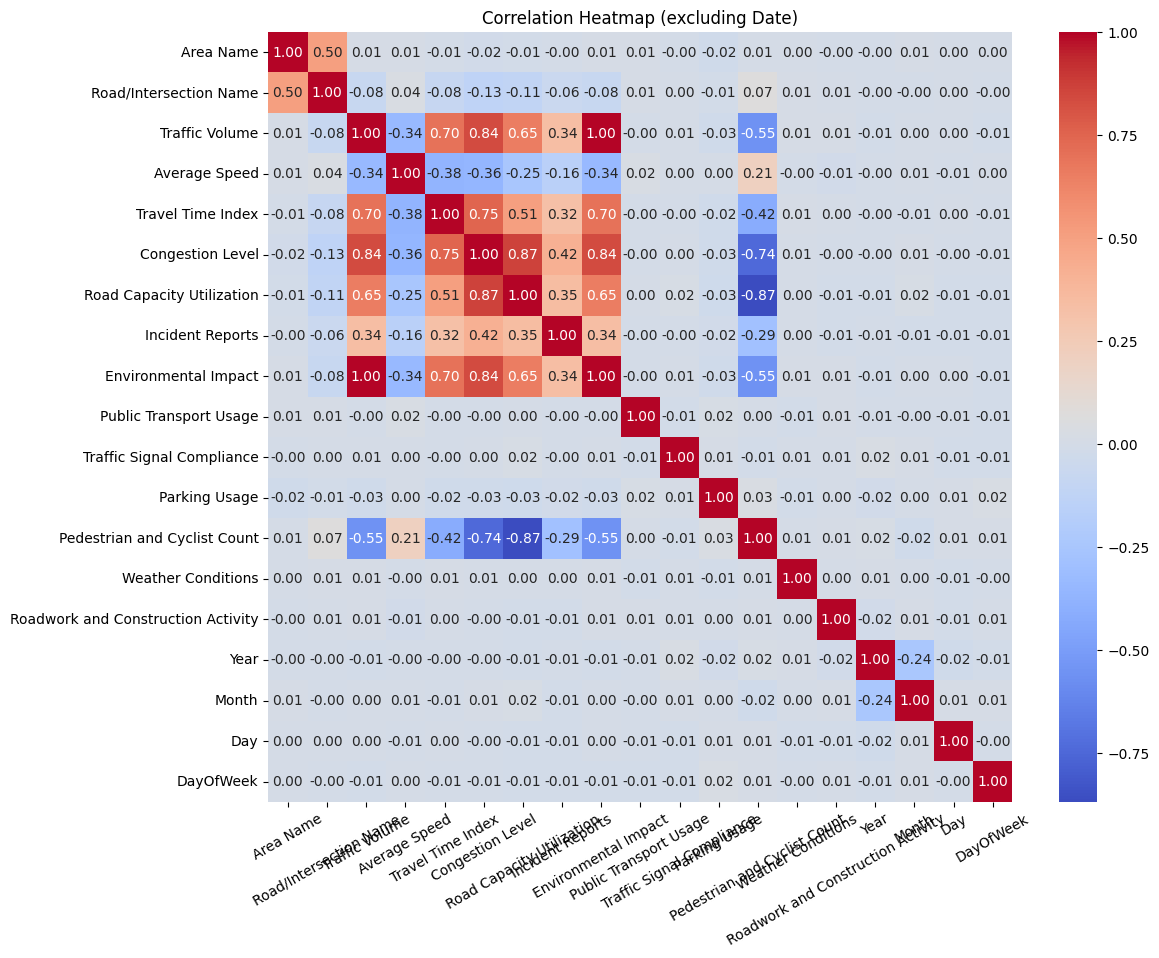

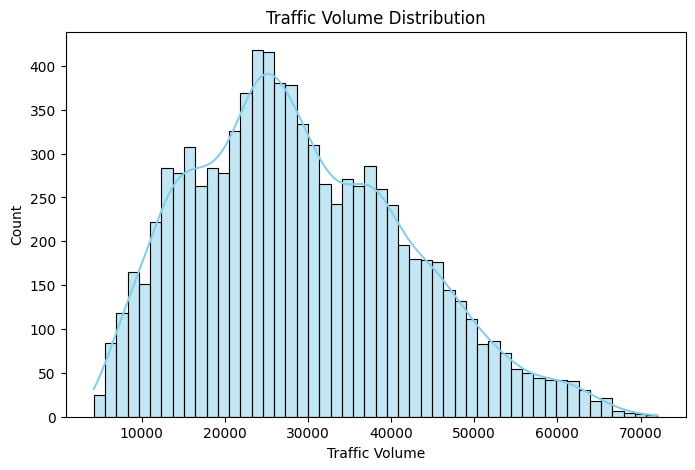

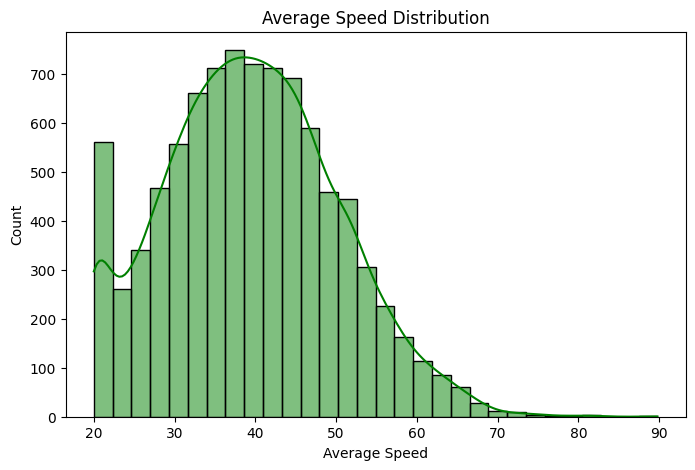

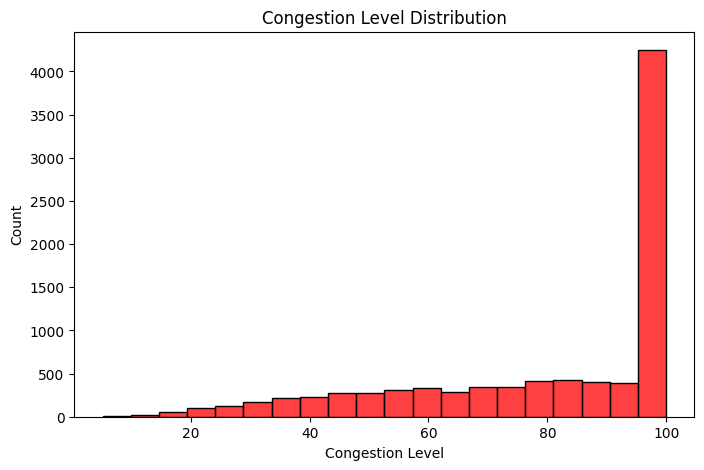

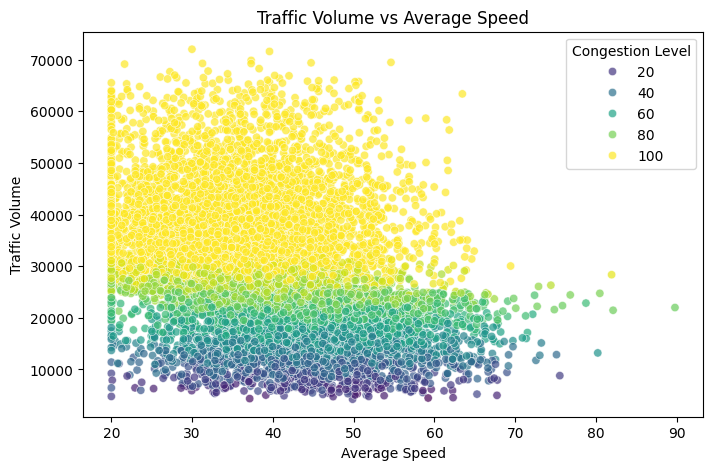

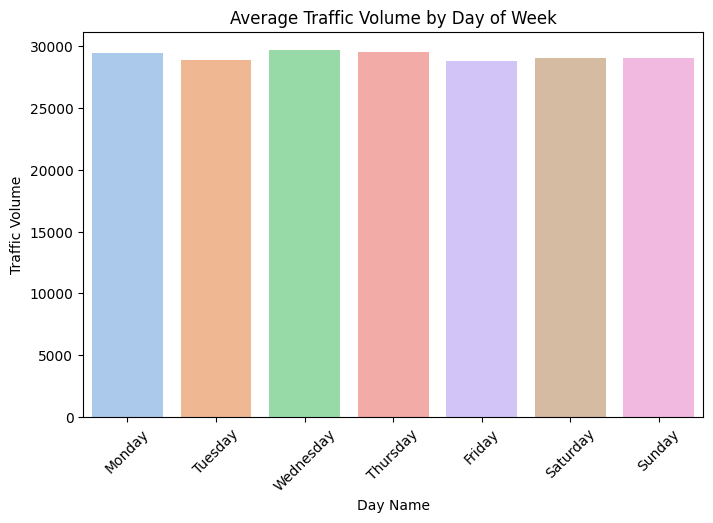

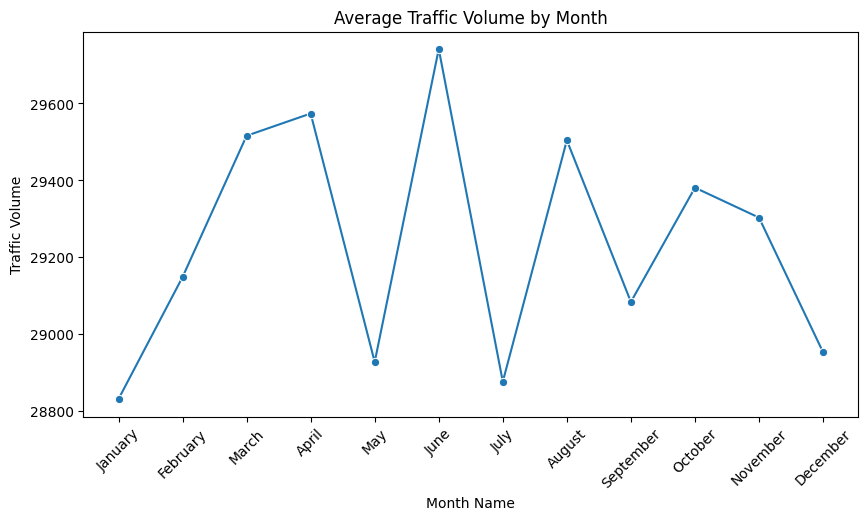

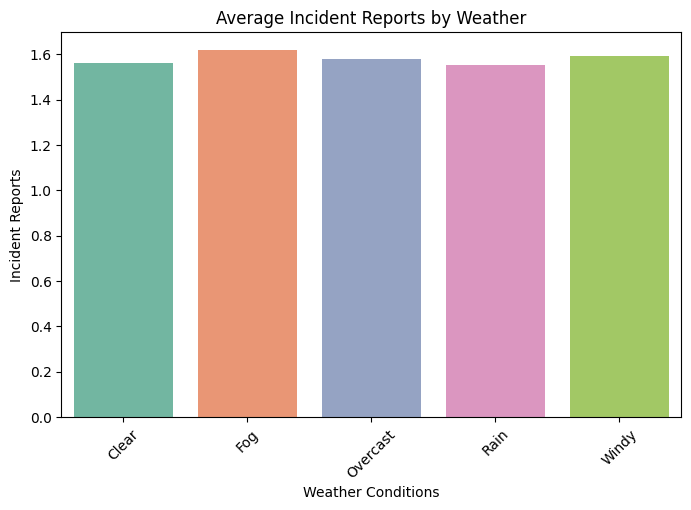

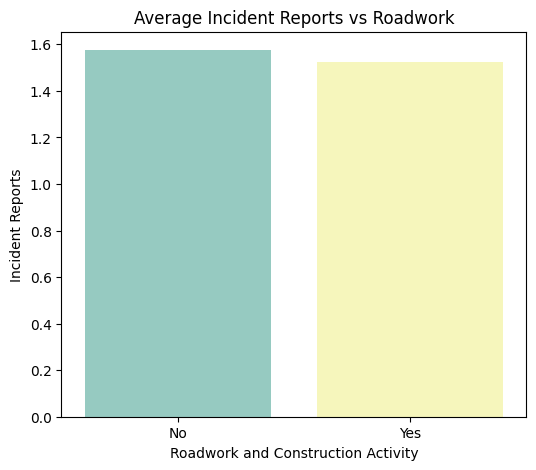

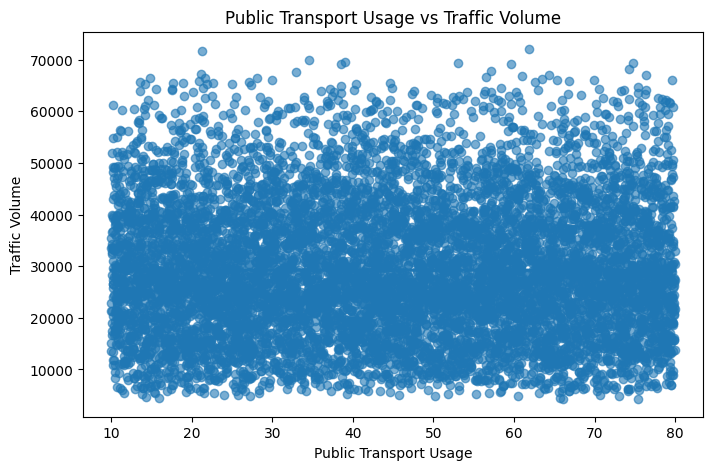

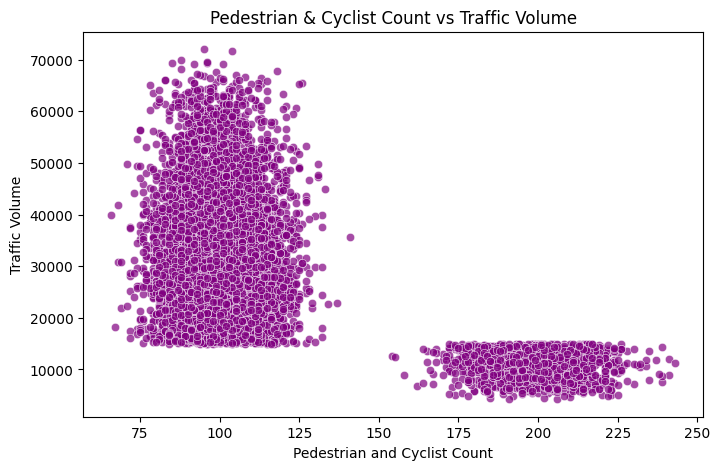

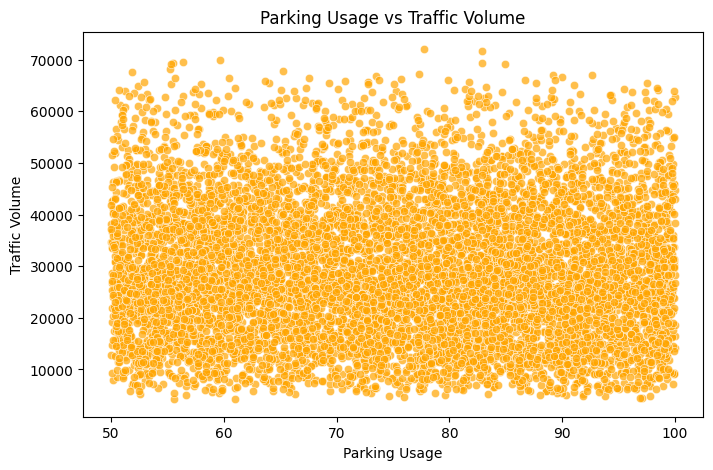

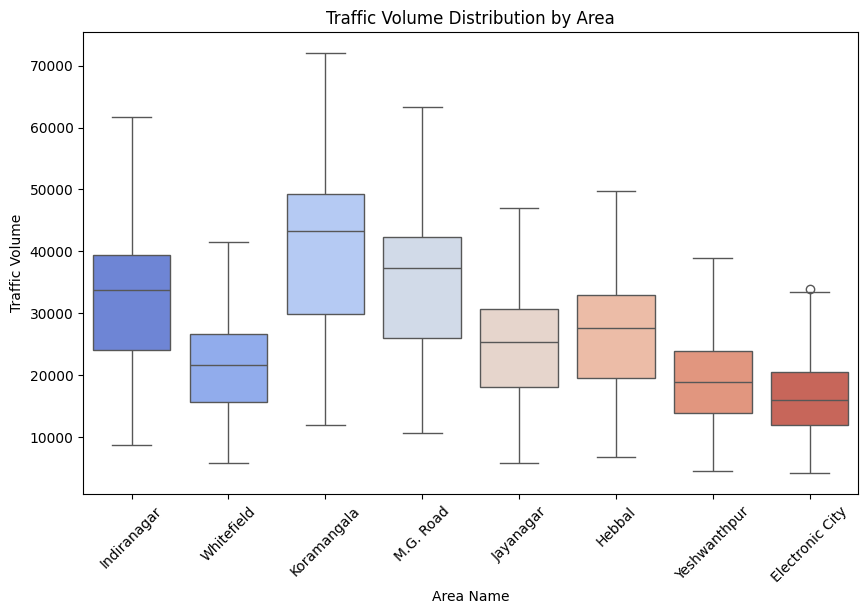

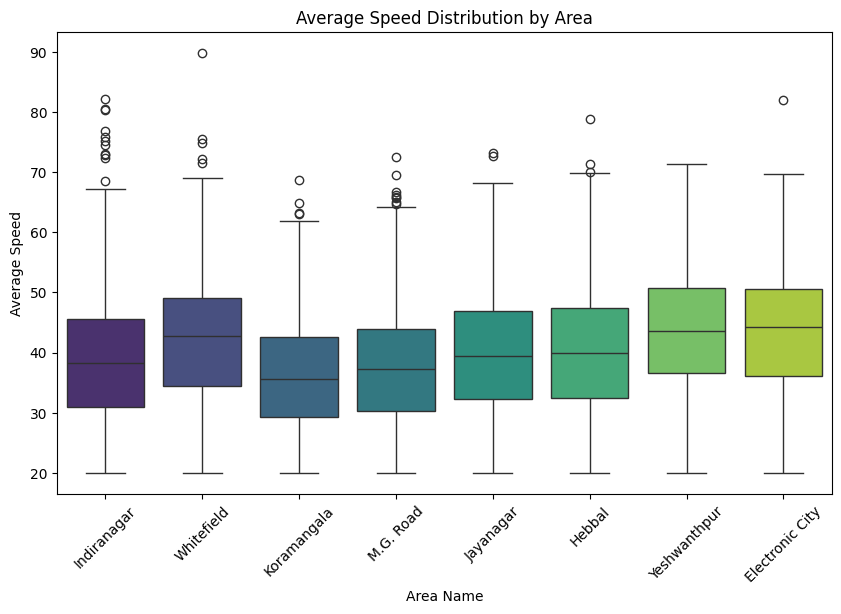

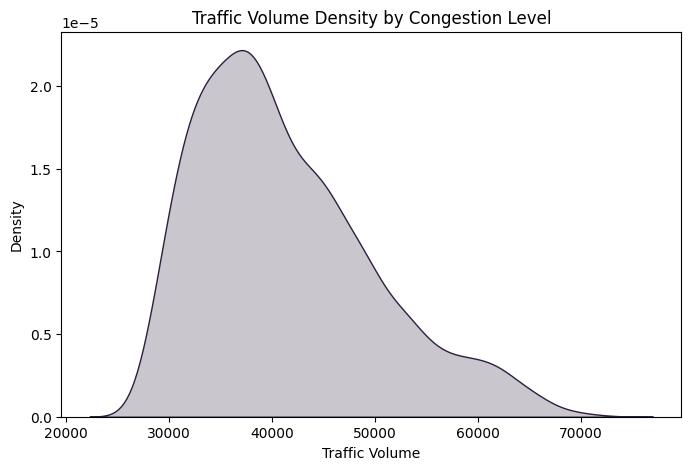

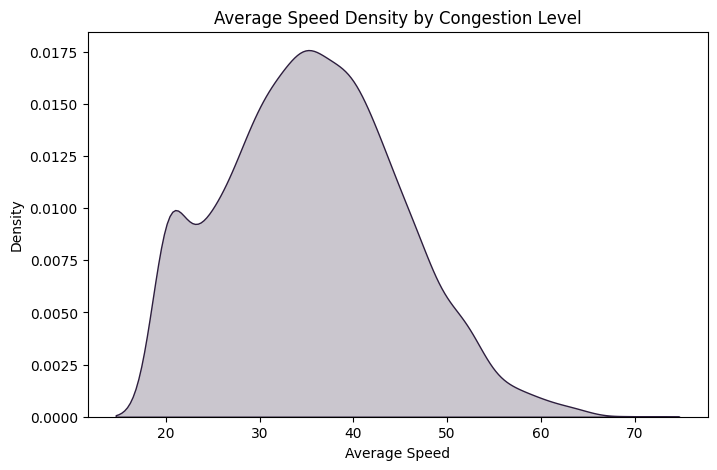

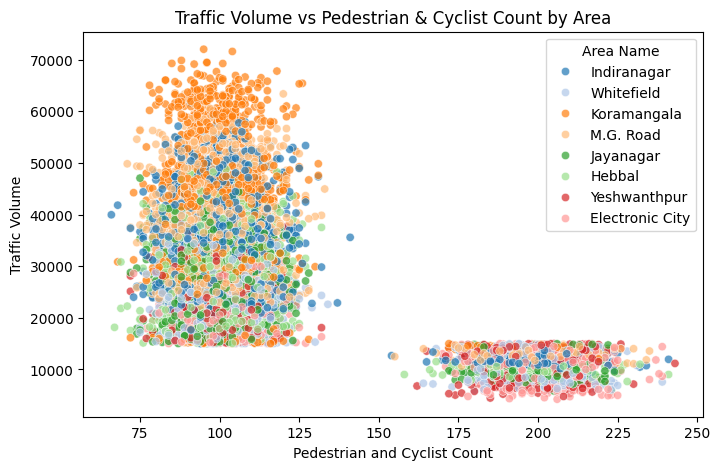

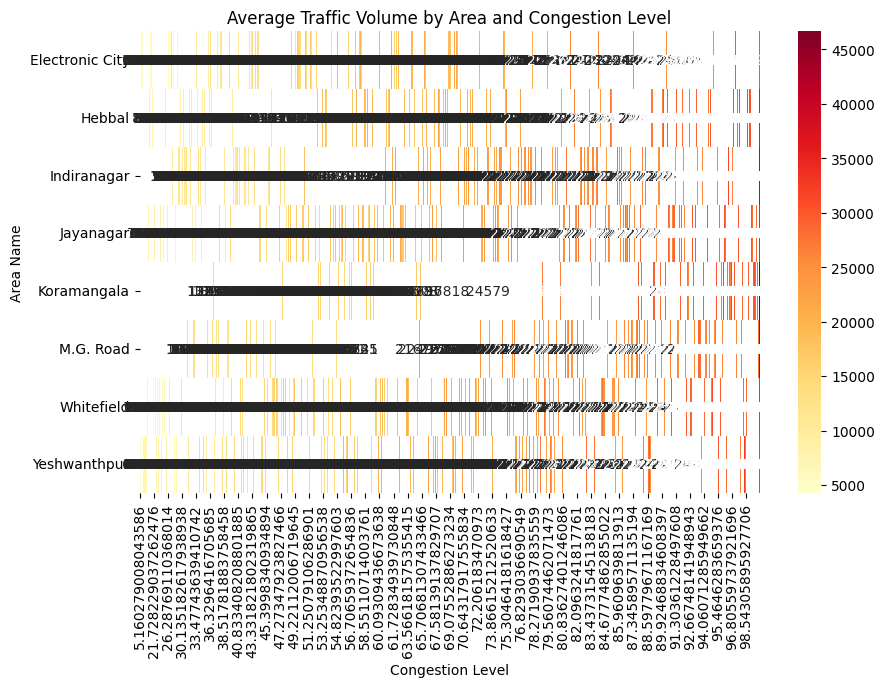

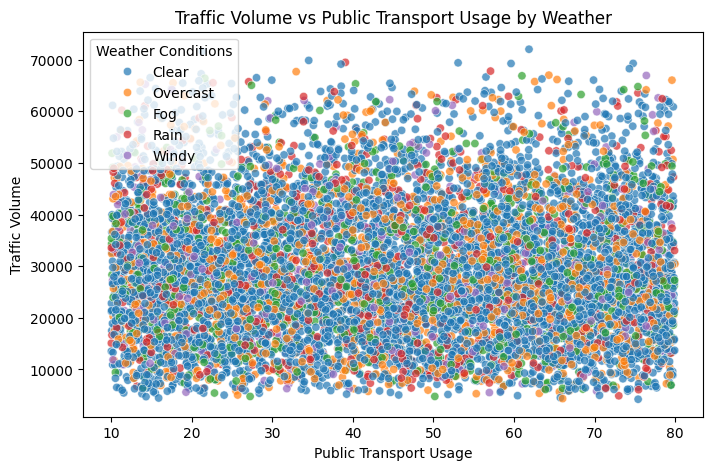

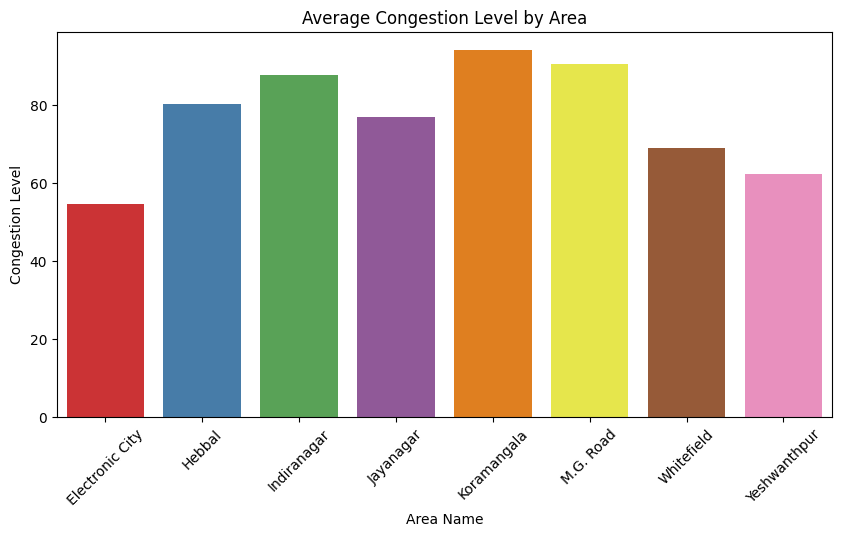

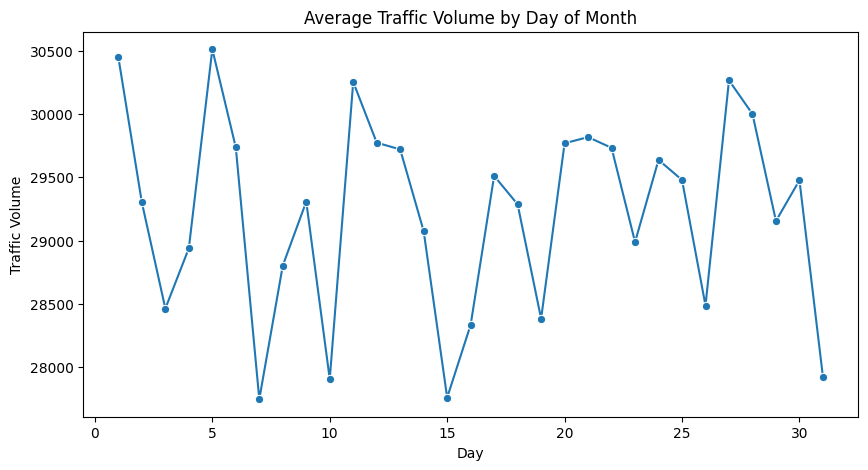

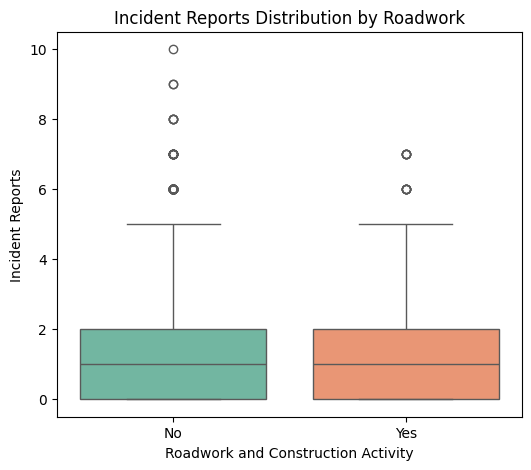

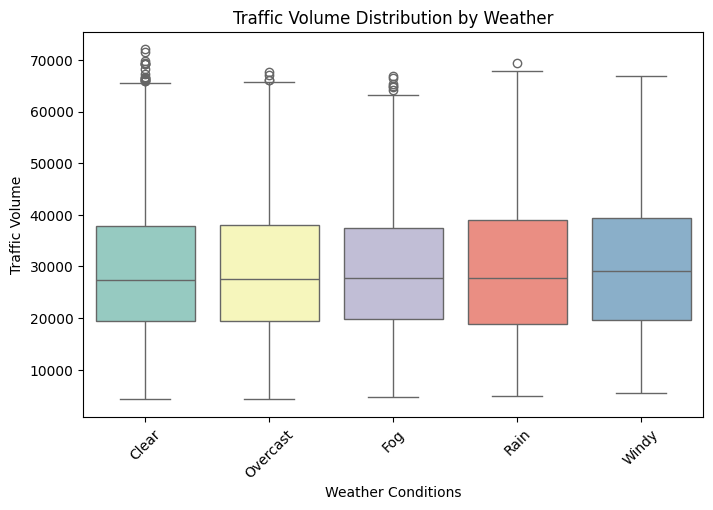

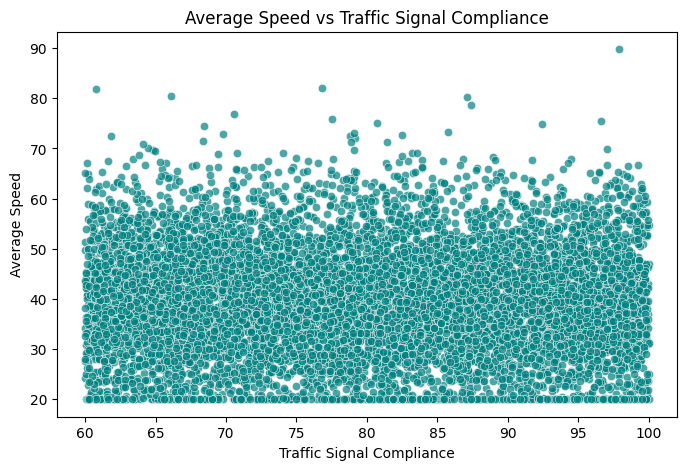

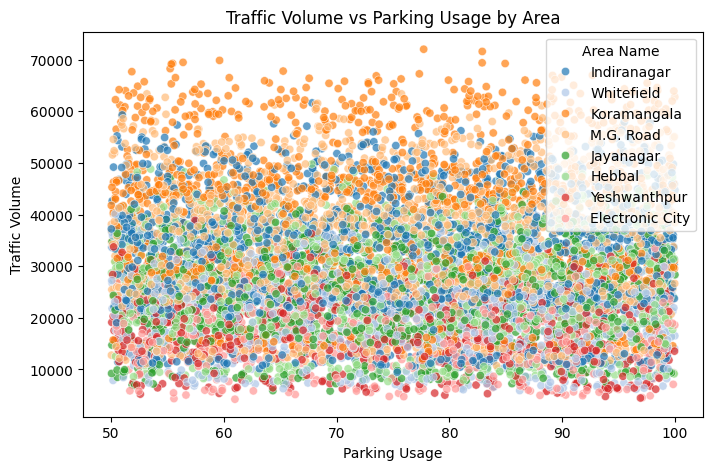

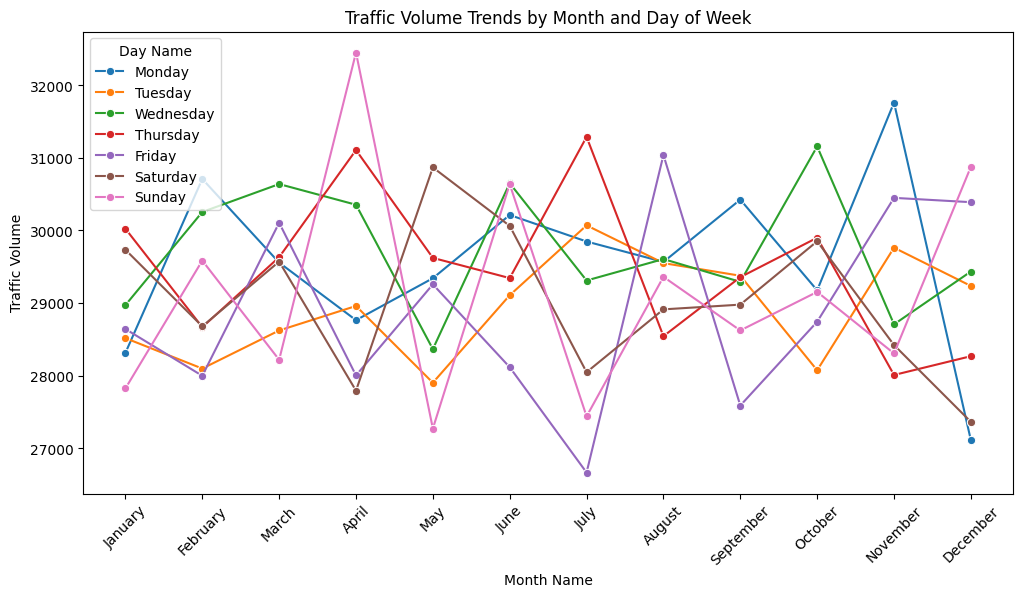

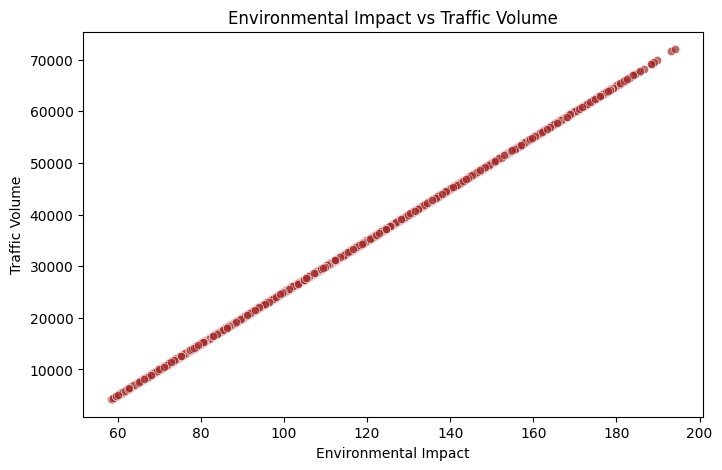

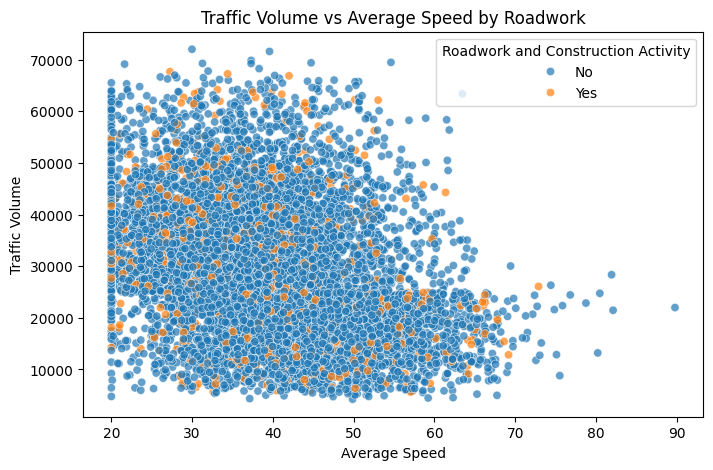

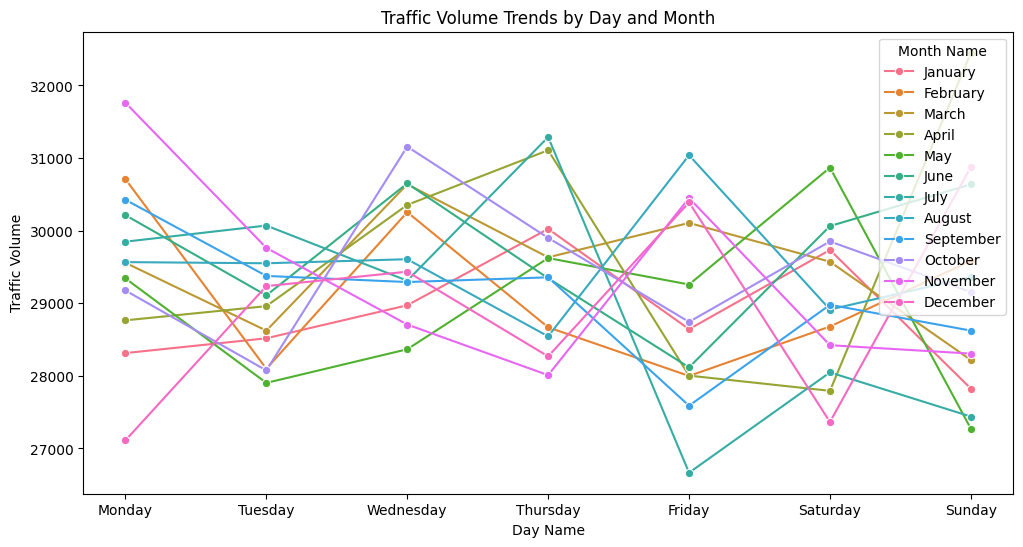

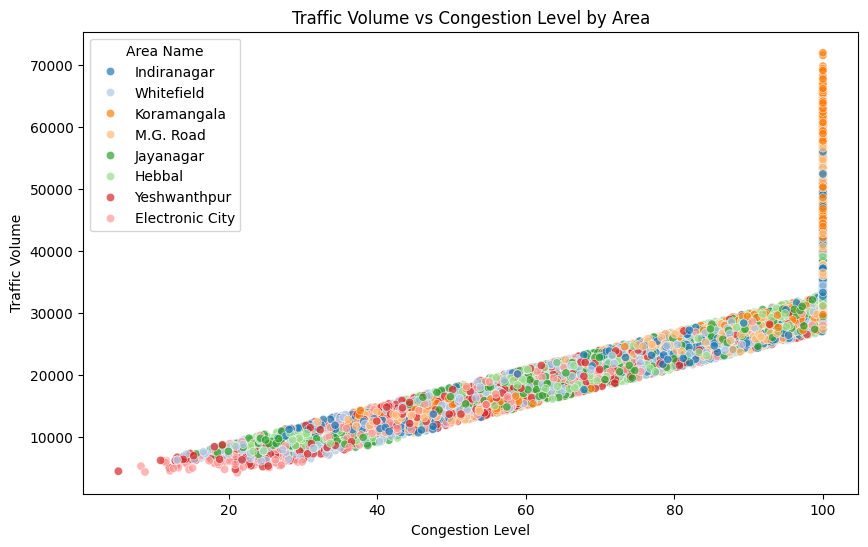

In [10]:
# Correlation heatmap (exclude Date)
plt.figure(figsize=(12,10))
sns.heatmap(df.drop(columns=['Date']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (excluding Date)")
plt.xticks(rotation=(30))
plt.show()

#Traffic Volume distribution (Histogram + KDE)
plt.figure(figsize=(8,5))
sns.histplot(df_plot['Traffic Volume'], bins=50, kde=True, color='skyblue')
plt.title("Traffic Volume Distribution")
plt.show()

# Average Speed distribution (Histogram + KDE)
plt.figure(figsize=(8,5))
sns.histplot(df_plot['Average Speed'], bins=30, kde=True, color='green')
plt.title("Average Speed Distribution")
plt.show()

# Congestion Level distribution (Histogram)
plt.figure(figsize=(8,5))
sns.histplot(df_plot['Congestion Level'], bins=20, kde=False, color='red')
plt.title("Congestion Level Distribution")
plt.show()

# Traffic Volume vs Average Speed (Scatterplot)
plt.figure(figsize=(8,5))
sns.scatterplot(x='Average Speed', y='Traffic Volume', hue='Congestion Level', palette='viridis', alpha=0.7, data=df_plot)
plt.title("Traffic Volume vs Average Speed")
plt.show()

# Traffic Volume by Day Name (Barplot)
plt.figure(figsize=(8,5))
sns.barplot(x='Day Name', y='Traffic Volume', data=df_plot.groupby('Day Name')['Traffic Volume'].mean().reset_index(), palette='pastel')
plt.title("Average Traffic Volume by Day of Week")
plt.xticks(rotation=45)
plt.show()

# Traffic Volume by Month Name (Lineplot)
plt.figure(figsize=(10,5))
sns.lineplot(x='Month Name', y='Traffic Volume', data=df_plot.groupby('Month Name')['Traffic Volume'].mean().reset_index(), marker='o')
plt.title("Average Traffic Volume by Month")
plt.xticks(rotation=45)
plt.show()

# Incidents vs Weather (Barplot)
plt.figure(figsize=(8,5))
sns.barplot(x='Weather Conditions', y='Incident Reports', data=df_plot.groupby('Weather Conditions')['Incident Reports'].mean().reset_index(), palette='Set2')
plt.title("Average Incident Reports by Weather")
plt.xticks(rotation=45)
plt.show()

# Incidents vs Roadwork (Barplot)
plt.figure(figsize=(6,5))
sns.barplot(x='Roadwork and Construction Activity', y='Incident Reports', data=df_plot.groupby('Roadwork and Construction Activity')['Incident Reports'].mean().reset_index(), palette='Set3')
plt.title("Average Incident Reports vs Roadwork")
plt.show()

# Public Transport Usage vs Traffic Volume 
plt.figure(figsize=(8,5))
sns.regplot(x='Public Transport Usage', y='Traffic Volume', data=df_plot, scatter_kws={'alpha':0.6})
plt.title("Public Transport Usage vs Traffic Volume")
plt.show()

# Pedestrian & Cyclist Count vs Traffic Volume (Scatterplot)
plt.figure(figsize=(8,5))
sns.scatterplot(x='Pedestrian and Cyclist Count', y='Traffic Volume', data=df_plot, alpha=0.7, color='purple')
plt.title("Pedestrian & Cyclist Count vs Traffic Volume")
plt.show()

# Parking Usage vs Traffic Volume (Scatterplot)
plt.figure(figsize=(8,5))
sns.scatterplot(x='Parking Usage', y='Traffic Volume', data=df_plot, alpha=0.7, color='orange')
plt.title("Parking Usage vs Traffic Volume")
plt.show()

# Traffic Volume by Area
plt.figure(figsize=(10,6))
sns.boxplot(x='Area Name', y='Traffic Volume', data=df_plot, palette='coolwarm')
plt.title("Traffic Volume Distribution by Area")
plt.xticks(rotation=45)
plt.show()

# Average Speed by Area
plt.figure(figsize=(10,6))
sns.boxplot(x='Area Name', y='Average Speed', data=df_plot, palette='viridis')
plt.title("Average Speed Distribution by Area")
plt.xticks(rotation=45)
plt.show()

# Traffic Volume by Congestion Level
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot, x='Traffic Volume', hue='Congestion Level', fill=True, legend=False)
plt.title("Traffic Volume Density by Congestion Level")
plt.show()

# Average Speed by Congestion Level
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot, x='Average Speed', hue='Congestion Level', fill=True, legend=False)
plt.title("Average Speed Density by Congestion Level")
plt.show()

# Traffic Volume vs Pedestrian & Cyclist Count, colored by Area
plt.figure(figsize=(8,5))
sns.scatterplot(x='Pedestrian and Cyclist Count', y='Traffic Volume', hue='Area Name', data=df_plot, palette='tab20', alpha=0.7)
plt.title("Traffic Volume vs Pedestrian & Cyclist Count by Area")
plt.show()

# Area vs Congestion Level (pivot)
pivot_df = df_plot.pivot_table(values='Traffic Volume', index='Area Name', columns='Congestion Level', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap='YlOrRd')
plt.title("Average Traffic Volume by Area and Congestion Level")
plt.show()

# Traffic Volume vs Public Transport Usage by Weather
plt.figure(figsize=(8,5))
sns.scatterplot(x='Public Transport Usage', y='Traffic Volume', hue='Weather Conditions', data=df_plot, palette='tab10', alpha=0.7)
plt.title("Traffic Volume vs Public Transport Usage by Weather")
plt.show()

# Average Congestion Level by Area
plt.figure(figsize=(10,5))
sns.barplot(x='Area Name', y='Congestion Level', data=df_plot.groupby('Area Name')['Congestion Level'].mean().reset_index(), palette='Set1')
plt.title("Average Congestion Level by Area")
plt.xticks(rotation=45)
plt.show()

# Traffic Volume across Days (Day number)
plt.figure(figsize=(10,5))
sns.lineplot(x='Day', y='Traffic Volume', data=df_plot.groupby('Day')['Traffic Volume'].mean().reset_index(), marker='o')
plt.title("Average Traffic Volume by Day of Month")
plt.show()

# Incidents by Roadwork
plt.figure(figsize=(6,5))
sns.boxplot(x='Roadwork and Construction Activity', y='Incident Reports', data=df_plot, palette='Set2')
plt.title("Incident Reports Distribution by Roadwork")
plt.show()

# Traffic Volume by Weather
plt.figure(figsize=(8,5))
sns.boxplot(x='Weather Conditions', y='Traffic Volume', data=df_plot, palette='Set3')
plt.title("Traffic Volume Distribution by Weather")
plt.xticks(rotation=45)
plt.show()

# Average Speed vs Traffic Signal Compliance
plt.figure(figsize=(8,5))
sns.scatterplot(x='Traffic Signal Compliance', y='Average Speed', data=df_plot, alpha=0.7, color='teal')
plt.title("Average Speed vs Traffic Signal Compliance")
plt.show()

# Traffic Volume vs Parking Usage
plt.figure(figsize=(8,5))
sns.scatterplot(x='Parking Usage', y='Traffic Volume', data=df_plot, alpha=0.7, hue='Area Name', palette='tab20')
plt.title("Traffic Volume vs Parking Usage by Area")
plt.show()

# Traffic Volume by Month and DayName 
plt.figure(figsize=(12,6))
sns.lineplot(x='Month Name', y='Traffic Volume', hue='Day Name',
    data=df_plot.groupby(['Month Name','Day Name'])['Traffic Volume'].mean().reset_index(),
    marker='o')
plt.title("Traffic Volume Trends by Month and Day of Week")
plt.xticks(rotation=45)
plt.show()

# Environmental Impact vs Traffic Volume
plt.figure(figsize=(8,5))
sns.scatterplot(x='Environmental Impact', y='Traffic Volume', data=df_plot, alpha=0.7, color='brown')
plt.title("Environmental Impact vs Traffic Volume")
plt.show()

# Traffic Volume vs Average Speed by Roadwork
plt.figure(figsize=(8,5))
sns.scatterplot(x='Average Speed', y='Traffic Volume', hue='Roadwork and Construction Activity', data=df_plot, palette='tab10', alpha=0.7)
plt.title("Traffic Volume vs Average Speed by Roadwork")
plt.show()

# Traffic Volume by DayName and Month (average)
plt.figure(figsize=(12,6))
sns.lineplot(x='Day Name', y='Traffic Volume', hue='Month Name',
    data=df_plot.groupby(['Day Name','Month Name'])['Traffic Volume'].mean().reset_index(),
    marker='o')
plt.title("Traffic Volume Trends by Day and Month")
plt.show()

# Traffic Volume vs Congestion Level by Area
plt.figure(figsize=(10,6))
sns.scatterplot(x='Congestion Level', y='Traffic Volume', hue='Area Name', data=df_plot, palette='tab20', alpha=0.7)
plt.title("Traffic Volume vs Congestion Level by Area")
plt.show()


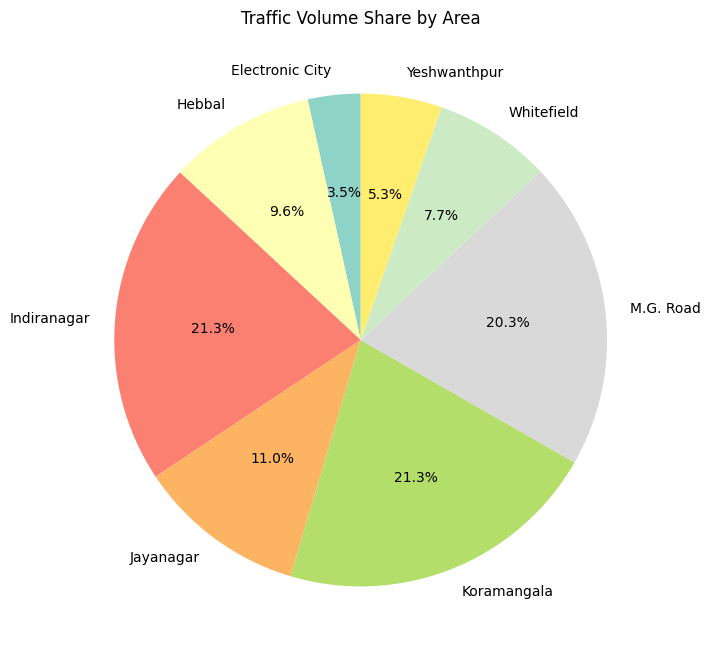

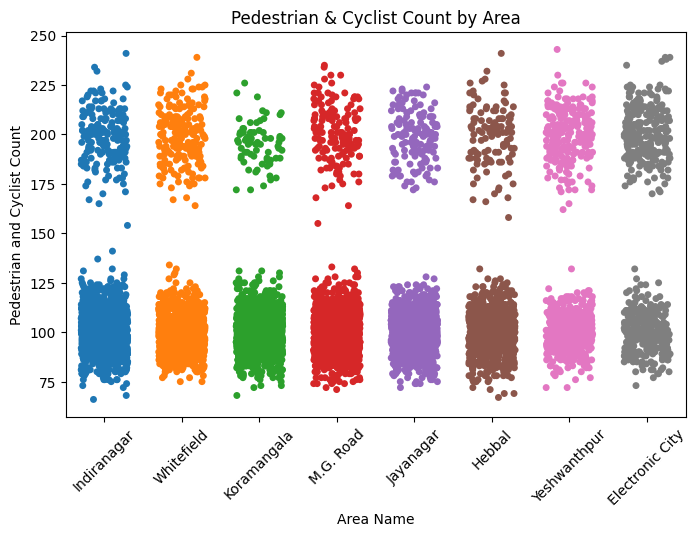

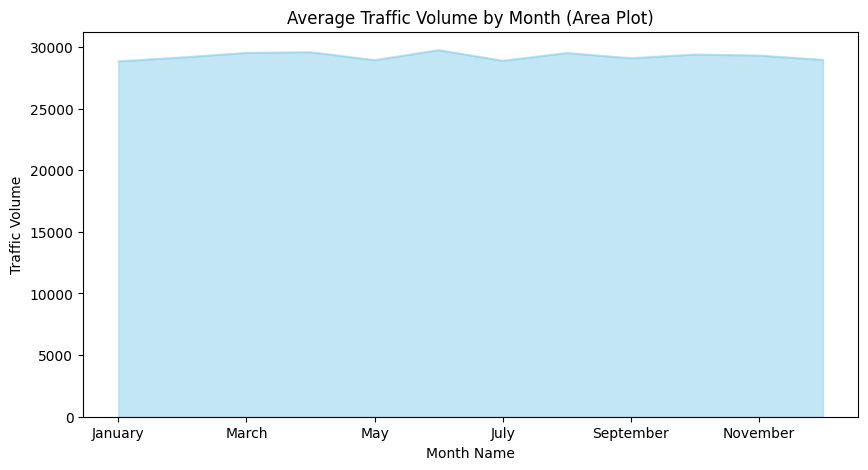

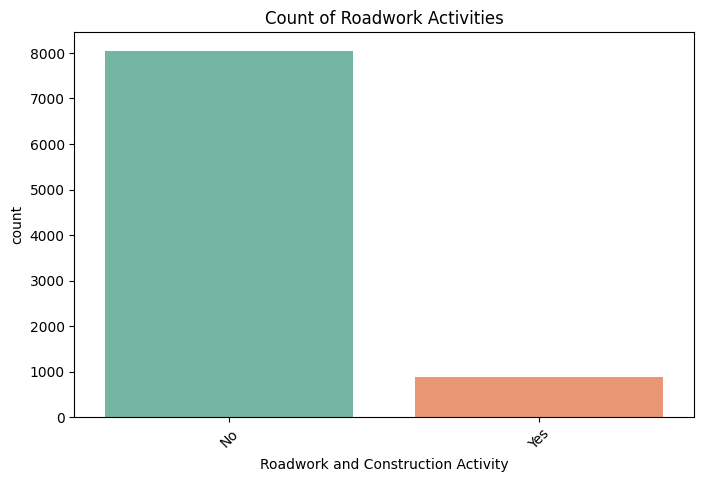

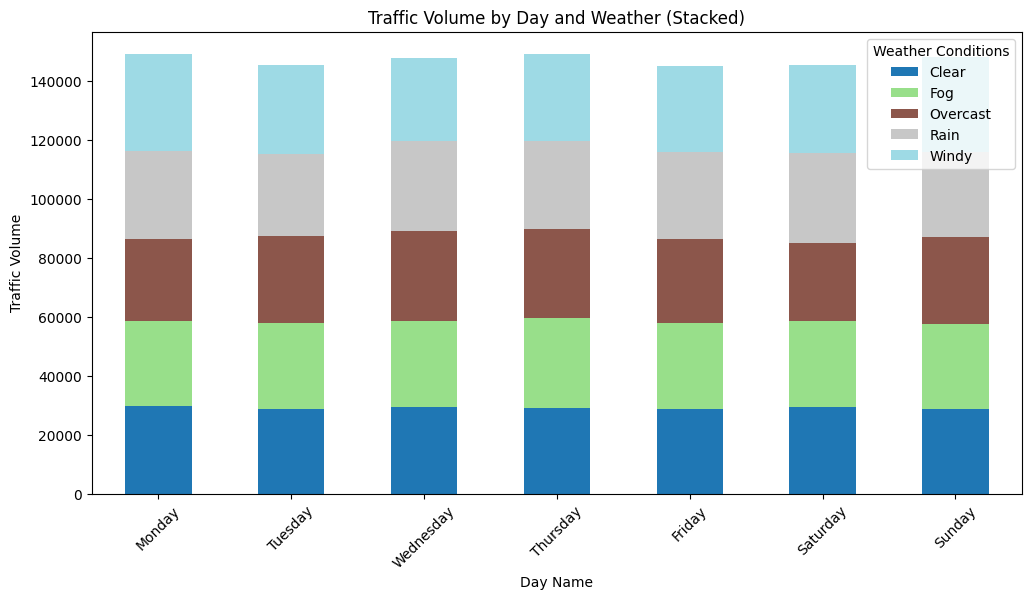

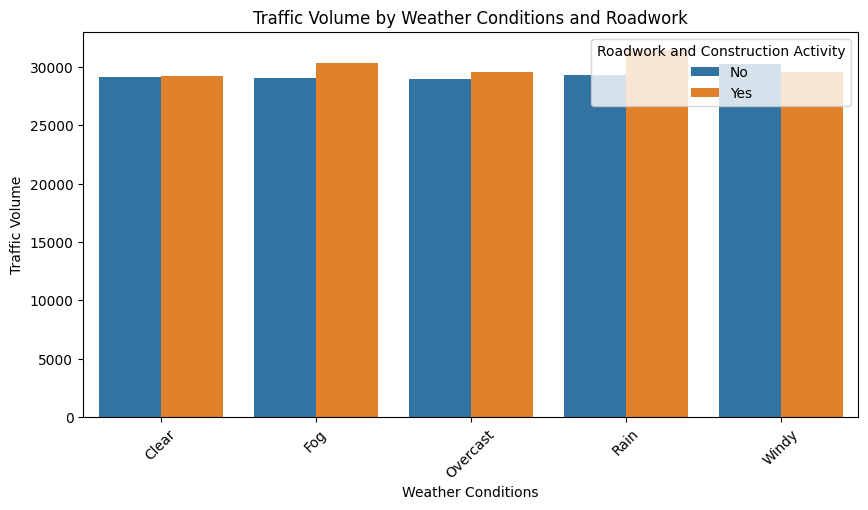

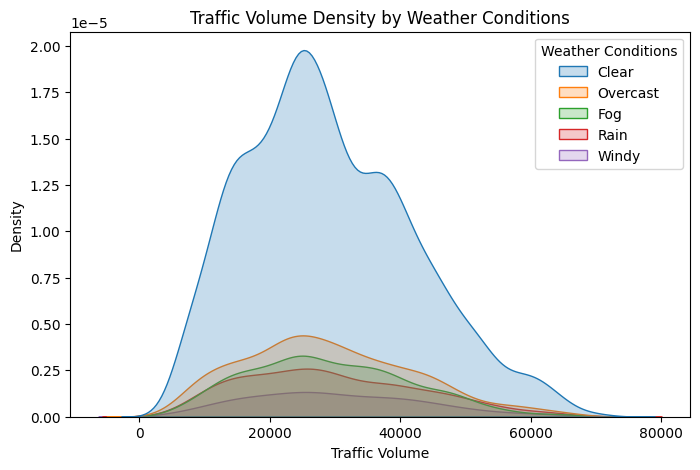

<Figure size 5000x5000 with 0 Axes>

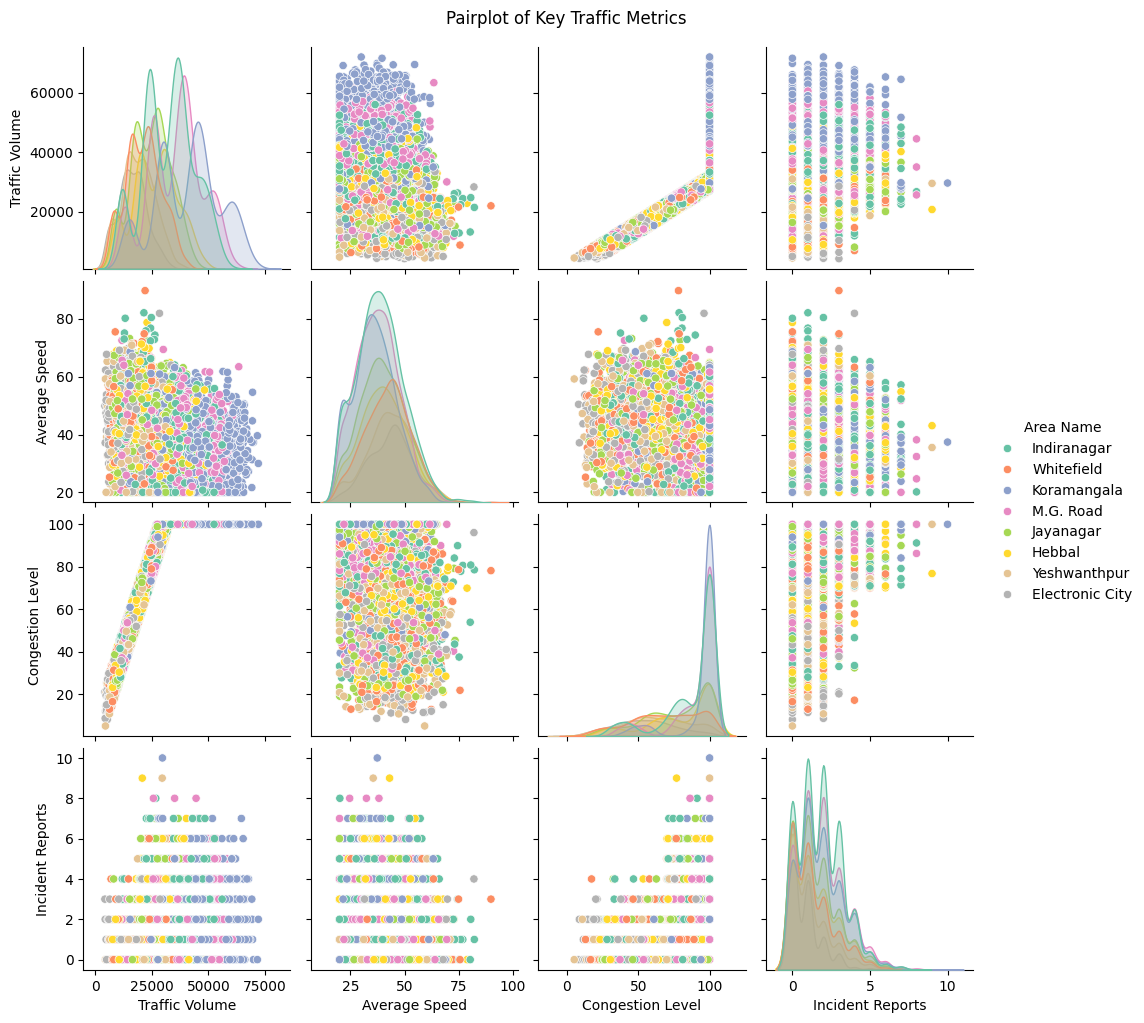

In [11]:
# Pie plot: Traffic Volume Share by Area
area_traffic = df_plot.groupby('Area Name')['Traffic Volume'].sum()
plt.figure(figsize=(8,8))
area_traffic.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title("Traffic Volume Share by Area")
plt.ylabel('')
plt.show()


# Stripplot: Pedestrian & Cyclist Count by Area
plt.figure(figsize=(8,5))
sns.stripplot(x='Area Name', y='Pedestrian and Cyclist Count', data=df_plot, palette='tab10', jitter=0.3)
plt.title("Pedestrian & Cyclist Count by Area")
plt.xticks(rotation=45)
plt.show()


# Area plot: Average Traffic Volume by Month
monthly_traffic = df_plot.groupby('Month Name')['Traffic Volume'].mean()
monthly_traffic.plot.area(figsize=(10,5), color='skyblue', alpha=0.5)
plt.title("Average Traffic Volume by Month (Area Plot)")
plt.ylabel("Traffic Volume")
plt.show()


# Countplot: Count of Roadwork Activities
plt.figure(figsize=(8,5))
sns.countplot(x='Roadwork and Construction Activity', data=df_plot, palette='Set2')
plt.title("Count of Roadwork Activities")
plt.xticks(rotation=45)
plt.show()


# Stacked bar: Traffic Volume by Day and Weather
weather_day = df_plot.groupby(['Day Name','Weather Conditions'])['Traffic Volume'].mean().unstack()
weather_day.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title("Traffic Volume by Day and Weather (Stacked)")
plt.ylabel("Traffic Volume")
plt.xticks(rotation=45)
plt.show()


# Barplot: Traffic Volume by Weather Conditions and Roadwork Activity
df_grouped = df_plot.groupby(['Weather Conditions','Roadwork and Construction Activity'])['Traffic Volume'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='Weather Conditions', y='Traffic Volume', hue='Roadwork and Construction Activity', data=df_grouped)
plt.title("Traffic Volume by Weather Conditions and Roadwork")
plt.xticks(rotation=45)
plt.show()


# KDE plot: Traffic Volume Density by Weather Conditions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot, x='Traffic Volume', hue='Weather Conditions', fill=True)
plt.title("Traffic Volume Density by Weather Conditions")
plt.show()


# Pairplot: Relationships between Traffic Volume, Average Speed, Congestion Level, and Incident Reports
plt.figure(figsize=(50,50))
sns.pairplot(df_plot[['Traffic Volume','Average Speed','Congestion Level','Incident Reports','Area Name']], 
    hue='Area Name', palette='Set2',diag_kind='kde')

plt.suptitle("Pairplot of Key Traffic Metrics", y=1.02)
plt.show()


In [12]:
import calendar

# numeric columns
numeric_cols = df_plot.select_dtypes(include=['int64','float64']).columns
df_numeric = df_plot[numeric_cols].copy()

# aggregated metrics
df_numeric['Traffic_per_Area'] = df_plot.groupby('Area Name')['Traffic Volume'].transform('sum')
df_numeric['AvgSpeed_per_Area'] = df_plot.groupby('Area Name')['Average Speed'].transform('mean')
df_numeric['Traffic_per_Weather'] = df_plot.groupby('Weather Conditions')['Traffic Volume'].transform('mean')
df_numeric['Traffic_per_Month'] = df_plot.groupby('Month Name')['Traffic Volume'].transform('mean')
df_numeric['Traffic_per_Day'] = df_plot.groupby('Day Name')['Traffic Volume'].transform('mean')

# time features
df_numeric['WeekOfYear'] = df_plot['Date'].dt.isocalendar().week
df_numeric['Quarter'] = df_plot['Date'].dt.quarter

# ratios
df_numeric['Traffic_per_Capacity'] = df_plot['Traffic Volume'] / df_plot['Road Capacity Utilization'].replace(0, 1)
df_numeric['Congestion_Impact'] = df_plot['Traffic Volume'] * (df_plot['Congestion Level'] / 100)

# incident and risk
df_numeric['Incident_Rate'] = df_plot['Incident Reports'] / df_plot['Traffic Volume'].replace(0, 1)

# pedestrian / public transport
df_numeric['Pedestrian_Ratio'] = df_plot['Pedestrian and Cyclist Count'] / df_plot['Traffic Volume'].replace(0, 1)
df_numeric['PublicTransport_Effect'] = df_plot['Traffic Volume'] / df_plot['Public Transport Usage'].replace(0, 1)
df_numeric['Parking_Load'] = df_plot['Parking Usage'] / df_plot['Traffic Volume'].replace(0, 1)

# environment
df_numeric['Env_Impact_per_Traffic'] = df_plot['Environmental Impact'] / df_plot['Traffic Volume'].replace(0, 1)

# variability
df_numeric['Traffic_std_per_Area'] = df_plot.groupby('Area Name')['Traffic Volume'].transform('std')
df_numeric['Traffic_cv_per_Area'] = df_numeric['Traffic_std_per_Area'] / df_numeric['Traffic_per_Area'].replace(0, 1)

# stats
summary_stats = df_numeric.describe().T
print(" Summary Statistics ")
print(summary_stats)

correlation_matrix = df_numeric.corr()
print("\n Correlation Matrix ")
print(correlation_matrix)

top_areas = df_plot.groupby('Area Name')['Traffic Volume'].sum().sort_values(ascending=False).head(5)
print("\n Top 5 Areas by Traffic Volume ")
print(top_areas)

top_days = df_plot.groupby('Day Name')['Traffic Volume'].mean().sort_values(ascending=False).head(5)
print("\n Top 5 Days by Average Traffic Volume ")
print(top_days)

top_months = df_plot.groupby('Month Name')['Traffic Volume'].mean().sort_values(ascending=False).head(5)
print("\n Top 5 Months by Average Traffic Volume ")
print(top_months)

traffic_incident_corr = df_plot[['Traffic Volume','Incident Reports']].corr()
print("\n Traffic vs Incident Reports Correlation ")
print(traffic_incident_corr)

traffic_congestion_corr = df_plot[['Traffic Volume','Congestion Level']].corr()
print("\n Traffic vs Congestion Level Correlation ")
print(traffic_congestion_corr)

avg_speed_congestion_corr = df_plot[['Average Speed','Congestion Level']].corr()
print("\n Average Speed vs Congestion Level Correlation ")
print(avg_speed_congestion_corr)

# save data
df_numeric.to_csv("./datasets/Banglore_feature_engg_numeric_traffic_dataset.csv", index=False)

df_num = df[['Date', 'Area Name', 'Road/Intersection Name', 'Traffic Volume',
    'Average Speed', 'Travel Time Index', 'Congestion Level',
    'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact',
    'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage',
    'Pedestrian and Cyclist Count', 'Weather Conditions',
    'Roadwork and Construction Activity']]

df_num.to_csv("./datasets/Banglore_traffic_to_numeric_Dataset.csv", index=False)


 Summary Statistics 
                               count             mean              std  \
Traffic Volume                8936.0      29236.04812     13001.808801   
Average Speed                 8936.0        39.447427        10.707244   
Travel Time Index             8936.0         1.375554         0.165319   
Congestion Level              8936.0        80.818041        23.533182   
Road Capacity Utilization     8936.0        92.029215        16.583341   
Incident Reports              8936.0         1.570389         1.420047   
Environmental Impact          8936.0       108.472096        26.003618   
Public Transport Usage        8936.0        45.086651         20.20846   
Traffic Signal Compliance     8936.0        79.950243        11.585006   
Parking Usage                 8936.0        75.155597        14.409394   
Pedestrian and Cyclist Count  8936.0       114.533348        36.812573   
Traffic_per_Area              8936.0  38370982.825873  17505700.383458   
AvgSpeed_per_Area

In [ ]:

eda_text = """
| Key Insights from Traffic EDA

> Out of a total of 8,936 traffic records, peak Traffic Volume reached 72,039 vehicles, 
  while the average was ~29,236 vehicles per record. Congestion is high, with an average 
  of ~81% and some areas reaching full capacity.

1. Area Traffic
   * Koramangala had the highest Traffic Volume: 55,695,194
   * Followed by Indiranagar: 55,529,148 and M.G. Road: 52,985,940
   * Jayanagar (28,857,360) and Hebbal (25,206,571) were next
   * Koramangala and Indiranagar alone accounted for nearly one-third of total traffic

2. Day of Week
   * Busiest days were Wednesday (29,698 avg), Thursday (29,530), and Monday (29,510)
   * Sunday (29,105) and Saturday (29,063) were slightly lower
   * Traffic is generally higher on weekdays than weekends

3. Month of Year
   * June recorded the highest average traffic: 29,742
   * April (29,574) and March (29,516) followed
   * August (29,504) and October (29,381) were also busy
   * Lowest traffic was observed in months outside this peak range

4. Congestion & Capacity
   * Traffic Volume strongly correlates with Congestion Level (0.84) and Road Capacity Utilization (0.65)
   * Some areas operate at over 380% of nominal capacity (Traffic_per_Capacity)
   * High congestion directly impacts travel time and environmental load

5. Speed & Travel Time
   * Average Speed ~39.4 km/h; slows down in high traffic areas
   * Travel Time Index correlates positively with Traffic Volume (0.70)
   * High congestion leads to slower travel and increased travel time

6. Incidents & Safety
   * Incident Reports are low on average (1.57 per record) but correlate with traffic hotspots (0.34)
   * Pedestrian Ratio negatively correlates with Traffic Volume (-0.69), suggesting crowded roads reduce pedestrian safety

7. Environmental Impact
   * Strong correlation with Traffic Volume (1.0) and congestion metrics
   * Environmental impact per traffic unit is low on average but peaks in heavily congested areas

8. Public Transport & Parking
   * Public Transport Effect moderately reduces congestion (correlation 0.53)
   * Parking Load negatively correlates with traffic volume (-0.76), indicating limited parking worsens congestion

9. Variability
   * Traffic_std_per_Area shows that some areas experience large fluctuations, requiring adaptive management
   * Traffic_cv_per_Area highlights variability relative to mean, useful for planning dynamic traffic interventions

10. Public Transport & Parking Effects
   * Areas with higher PublicTransport Effect show moderately lower congestion (correlation 0.53), while limited parking worsens traffic (correlation -0.76)

10. Public Transport & Parking Insights
    * Areas with higher PublicTransport Effect show moderately lower congestion (correlation 0.53).
    * Limited parking worsens traffic (Parking Load correlation -0.76), highlighting the need for real-time parking management.
    * Promoting public transport and park-and-ride facilities can significantly ease peak congestion.

11. Environmental Impact
    * Environmental Impact is perfectly correlated with Traffic Volume (1.0) and strongly with congestion metrics.
    * Heavily congested areas contribute the most to pollution, emphasizing the need for eco-friendly traffic strategies.
    * Focused interventions in high-traffic zones can reduce emissions effectively.

12. Real-Time Traffic Variability
    * Traffic_std_per_Area shows that some areas experience large fluctuations in traffic, requiring dynamic management.
    * Traffic_cv_per_Area highlights variability relative to mean, useful for predictive and adaptive traffic control systems.
    * High variability indicates the potential for real-time predictive models to optimize signal timings and lane allocation.

13. Correlation Highlights
    * Traffic Volume vs Congestion Level: 0.84 — higher traffic directly increases congestion.
    * Traffic Volume vs Travel Time Index: 0.70 — more vehicles result in slower travel.
    * Traffic Volume vs Road Capacity Utilization: 0.65 — traffic closely relates to how much of the road capacity is used.
    * Pedestrian Ratio vs Traffic Volume: -0.69 — crowded roads reduce pedestrian safety.
    * Parking Load vs Traffic Volume: -0.76 — limited parking worsens congestion.

Key Takeaways::
1. Traffic Volume vs Congestion Level: High traffic volume generally correlates with higher congestion.
2. Average Speed vs Congestion Level: As congestion increases, average speed decreases — clear negative correlation.High traffic volume areas correspond to high 
   congestion, longer travel times, and increased environmental impact.
3. Incident Reports: Areas with higher incidents often coincide with higher congestion and traffic volume.
4. Area-wise Differences: Using colors by Area Name, you can see some areas consistently have higher congestion or lower speed.
5. Public transport adoption and parking optimization can meaningfully reduce congestion.
"""
print(eda_text)


In [ ]:
traffic_recommendations = """
| Traffic Recommendations 

1. Focus on Busy Areas:
   - Prioritize Koramangala, Indiranagar, and M.G. Road, which consistently see the highest traffic.
   - Install adaptive traffic lights that respond in real time to traffic flow.
   - Encourage alternate routes, staggered work hours, or flexible office timings to reduce peak-hour congestion.
   - Consider micro-zoning: break large congested areas into smaller sections for targeted interventions.

2. Keep Traffic Moving:
   - Implement dynamic lane management and variable speed limits in congested zones.
   - Use real-time traffic data to detect slow zones and deploy quick interventions.
   - Explore congestion pricing, carpool incentives, and temporary vehicle restrictions during peak hours.
   - Optimize traffic signal timings based on historical and current traffic patterns.

3. Improve Safety:
   - Deploy monitoring cameras, rapid-response teams, and accident alert systems in hotspots.
   - Enhance pedestrian and cyclist infrastructure (crossings, signals, dedicated lanes).
   - Increase safety awareness campaigns on weekdays with highest traffic (Monday, Wednesday, Thursday).
   - Analyze incident reports to proactively fix high-risk road segments.

4. Public Transport and Parking:
   - Promote public transport usage in heavy-traffic areas with incentives or discounted passes.
   - Introduce real-time parking guidance and increase parking availability near congested areas.
   - Consider park-and-ride facilities outside core traffic zones to reduce inner-city congestion.
   - Encourage multi-modal travel: combine bikes, metro, buses, and walking for first/last-mile connectivity.

5. Environmental Considerations:
   - Focus interventions on areas with highest pollution and congestion.
   - Promote electric vehicles, low-emission zones, and eco-friendly transport alternatives.
   - Track emissions in real time to identify and prioritize environmental hotspots.
   - Encourage green corridors and urban planning to reduce traffic-induced environmental impact.

6. Plan Smart with Data:
   - Leverage historical and real-time traffic data for predictive modeling.
   - Identify peak months (June, April, March) and peak times to proactively manage flow.
   - Track traffic volume, congestion, incidents, and environmental impact continuously.
   - Integrate data-driven dashboards for decision-making and public alerts.

7. Behavioral & Community Actions:
   - Educate drivers on alternative routes and congestion-prone zones.
   - Encourage carpooling and shared mobility to reduce individual car usage.
   - Involve local communities in reporting traffic issues and hazards.
   - Launch apps or notifications to alert drivers about traffic conditions in real time.

8. Key Takeaways:
   - Koramangala and Indiranagar alone handle nearly one-third of total traffic — interventions there yield maximum impact.
   - Weekdays have higher traffic than weekends; strategies should be time-specific.
   - Monitor travel times, congestion, and incidents regularly to anticipate bottlenecks.
   - Pedestrian and cyclist safety must remain a top priority in congested zones.
   - Use variability metrics (Traffic_std_per_Area, Traffic_cv_per_Area) to design adaptive real-time traffic strategies.

"""
print(traffic_recommendations)


In [ ]:
df.head()

Date  Area Name  Road/Intersection Name  Traffic Volume  \
0 2022-01-01          2                       0           50590   
1 2022-01-01          2                       3           30825   
2 2022-01-01          6                       8            7399   
3 2022-01-01          4                      11           60874   
4 2022-01-01          4                       9           57292   

   Average Speed  Travel Time Index  Congestion Level  \
0      50.230299           1.500000        100.000000   
1      29.377125           1.500000        100.000000   
2      54.474398           1.039069         28.347994   
3      43.817610           1.500000        100.000000   
4      41.116763           1.500000        100.000000   

   Road Capacity Utilization  Incident Reports  Environmental Impact  \
0                 100.000000                 0               151.180   
1                 100.000000                 1               111.650   
2                  36.396525                 0                64.798   
3                 100.000000                 1               171.748   
4                 100.000000                 3               164.584   

   Public Transport Usage  Traffic Signal Compliance  Parking Usage  \
0               70.632330                  84.044600      85.403629   
1               41.924899                  91.407038      59.983689   
2               44.662384                  61.375541      95.466020   
3               32.773123                  75.547092      63.567452   
4               35.092601                  64.634762      93.155171   

   Pedestrian and Cyclist Count  Weather Conditions  \
0                           111                   0   
1                           100                   0   
2                           189                   0   
3                           111                   0   
4                           104                   0   

   Roadwork and Construction Activity  Year  Month  Day  DayOfWeek  
0                                   0  2022      1    1          5  
1                                   0  2022      1    1          5  
2                                   0  2022      1    1          5  
3                                   0  2022      1    1          5  
4                                   0  2022      1    1          5

In [ ]:
# Import ML Libraries
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create folder if not exists
os.makedirs("models", exist_ok=True)

# Model 1: Traffic Volume (Independent of 'Congestion Level', 'Average Speed')
X1 = df.drop(columns=['Traffic Volume', 'Congestion Level', 'Average Speed', 'Date'])
y1 = df['Traffic Volume']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1 = RandomForestRegressor(n_estimators=200, random_state=42)
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)

# Metrics for evaluation
rmse1 = mean_squared_error(y1_test, y1_pred) ** 0.5
mae1 = mean_absolute_error(y1_test, y1_pred)
mape1 = np.mean(np.abs((y1_test - y1_pred) / y1_test)) * 100
r2_1 = r2_score(y1_test, y1_pred)
corr1 = np.corrcoef(y1_test, y1_pred)[0,1]

print(" Model 1: Traffic Volume (Independent) ")
print(f"R2 Score: {r2_1:.4f}, RMSE: {rmse1:.4f}, MAE: {mae1:.4f}, MAPE: {mape1:.2f}%, Correlation: {corr1:.4f}\n")

joblib.dump(model1, 'models/model1_traffic_volume_independent.pkl')


# Model 2: Congestion Level (Independent of 'Traffic Volume', 'Average Speed')
X2 = df.drop(columns=['Congestion Level', 'Traffic Volume', 'Average Speed', 'Date'])
y2 = df['Congestion Level']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2 = RandomForestRegressor(n_estimators=200, random_state=42)
model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)

rmse2 = mean_squared_error(y2_test, y2_pred) ** 0.5
mae2 = mean_absolute_error(y2_test, y2_pred)
mape2 = np.mean(np.abs((y2_test - y2_pred) / y2_test)) * 100
r2_2 = r2_score(y2_test, y2_pred)
corr2 = np.corrcoef(y2_test, y2_pred)[0,1]

print(" Model 2: Congestion Level (Independent) ")
print(f"R2 Score: {r2_2:.4f}, RMSE: {rmse2:.4f}, MAE: {mae2:.4f}, MAPE: {mape2:.2f}%, Correlation: {corr2:.4f}\n")

joblib.dump(model2, 'models/model2_congestion_level_independent.pkl')


# Model 3: Average Speed (Independent of 'Traffic Volume', 'Congestion Level')
X3 = df.drop(columns=['Average Speed', 'Traffic Volume', 'Congestion Level', 'Date'])
y3 = df['Average Speed']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
model3 = RandomForestRegressor(n_estimators=200, random_state=42)
model3.fit(X3_train, y3_train)
y3_pred = model3.predict(X3_test)

rmse3 = mean_squared_error(y3_test, y3_pred) ** 0.5
mae3 = mean_absolute_error(y3_test, y3_pred)
mape3 = np.mean(np.abs((y3_test - y3_pred) / y3_test)) * 100
r2_3 = r2_score(y3_test, y3_pred)
corr3 = np.corrcoef(y3_test, y3_pred)[0,1]

print(" Model 3: Average Speed (Independent) ")
print(f"R2 Score: {r2_3:.4f}, RMSE: {rmse3:.4f}, MAE: {mae3:.4f}, MAPE: {mape3:.2f}%, Correlation: {corr3:.4f}\n")

joblib.dump(model3, 'models/model3_average_speed_independent.pkl')


# Model 4: Traffic Volume (With Congestion & Avg Speed)
X4 = df.drop(columns=['Traffic Volume', 'Date'])
y4 = df['Traffic Volume']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
model4 = RandomForestRegressor(n_estimators=200, random_state=42)
model4.fit(X4_train, y4_train)
y4_pred = model4.predict(X4_test)

rmse4 = mean_squared_error(y4_test, y4_pred) ** 0.5
mae4 = mean_absolute_error(y4_test, y4_pred)
mape4 = np.mean(np.abs((y4_test - y4_pred) / y4_test)) * 100
r2_4 = r2_score(y4_test, y4_pred)
corr4 = np.corrcoef(y4_test, y4_pred)[0,1]

print(" Model 4: Traffic Volume (With Congestion & Avg Speed) ")
print(f"R2 Score: {r2_4:.4f}, RMSE: {rmse4:.4f}, MAE: {mae4:.4f}, MAPE: {mape4:.2f}%, Correlation: {corr4:.4f}\n")

joblib.dump(model4, 'models/model4_traffic_volume_with_features.pkl')




 Model 1: Traffic Volume (Independent) 
R2 Score: 1.0000, RMSE: 35.5558, MAE: 7.4145, MAPE: 0.03%, Correlation: 1.0000

 Model 2: Congestion Level (Independent) 
R2 Score: 0.9653, RMSE: 4.3341, MAE: 2.8535, MAPE: 5.06%, Correlation: 0.9825

 Model 3: Average Speed (Independent) 
R2 Score: 0.1605, RMSE: 9.6861, MAE: 7.7424, MAPE: 21.66%, Correlation: 0.4049

 Model 4: Traffic Volume (With Congestion & Avg Speed) 
R2 Score: 1.0000, RMSE: 34.6053, MAE: 7.5312, MAPE: 0.03%, Correlation: 1.0000



['models/model4_traffic_volume_with_features.pkl']

In [63]:
# Load Models and Predict
import joblib
import pandas as pd

# Load models
model1 = joblib.load('models/model1_traffic_volume_independent.pkl')
model2 = joblib.load('models/model2_congestion_level_independent.pkl')
model3 = joblib.load('models/model3_average_speed_independent.pkl')
model4 = joblib.load('models/model4_traffic_volume_with_features.pkl')

# Ensure predictions don't leak into X
# Model 1: Traffic Volume (Independent)
X1 = df.drop(columns=['Traffic Volume', 'Congestion Level', 'Average Speed', 'Date'] 
             + [c for c in df.columns if c.startswith("Pred_")])
df['Pred_Traffic_Volume_Ind'] = model1.predict(X1)

# Model 2: Congestion Level (Independent)
X2 = df.drop(columns=['Congestion Level', 'Traffic Volume', 'Average Speed', 'Date'] 
             + [c for c in df.columns if c.startswith("Pred_")])
df['Pred_Congestion_Level_Ind'] = model2.predict(X2)

# Model 3: Average Speed (Independent)
X3 = df.drop(columns=['Average Speed', 'Traffic Volume', 'Congestion Level', 'Date'] 
             + [c for c in df.columns if c.startswith("Pred_")])
df['Pred_Average_Speed_Ind'] = model3.predict(X3)

# Model 4: Traffic Volume (With Congestion & Avg Speed)
X4 = df.drop(columns=['Traffic Volume', 'Date'] 
             + [c for c in df.columns if c.startswith("Pred_")])
df['Pred_Traffic_Volume_With_Features'] = model4.predict(X4)


# showall models data
print(" Model 1: Traffic Volume (Independent) ")
print(df[['Traffic Volume', 'Pred_Traffic_Volume_Ind']].head(10))

print("\n Model 2: Congestion Level (Independent) ")
print(df[['Congestion Level', 'Pred_Congestion_Level_Ind']].head(10))

print("\n Model 3: Average Speed (Independent) ")
print(df[['Average Speed', 'Pred_Average_Speed_Ind']].head(10))

print("\n Model 4: Traffic Volume (With Congestion & Avg Speed) ")
print(df[['Traffic Volume', 'Pred_Traffic_Volume_With_Features']].head(10))


 Model 1: Traffic Volume (Independent) 
   Traffic Volume  Pred_Traffic_Volume_Ind
0           50590                50576.400
1           30825                30825.770
2            7399                 7406.255
3           60874                60879.025
4           57292                57314.630
5           47848                47850.600
6           36574                36572.870
7           25379                25376.430
8           25022                25021.955
9           31760                31762.145

 Model 2: Congestion Level (Independent) 
   Congestion Level  Pred_Congestion_Level_Ind
0        100.000000                 100.000000
1        100.000000                  99.553516
2         28.347994                  26.658873
3        100.000000                 100.000000
4        100.000000                 100.000000
5        100.000000                 100.000000
6        100.000000                 100.000000
7         79.038823                  80.941500
8         78.979596  